# Heart Disease Prediction Model

This notebook demonstrates the development of a machine learning model to predict heart disease based on patient data. We'll go through data exploration, visualization, feature analysis, model building, hyperparameter tuning, and model comparison.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
import xgboost as xgb
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Exploration

In [2]:
# Load the heart disease dataset
dataset_path = os.path.join('..', 'datasets', 'heart', 'heart.csv')
data = pd.read_csv(dataset_path)

# Display basic information
print(f"Dataset shape: {data.shape}")
print(f"\nFirst 5 rows:")
display(data.head())

# Check for missing values
print(f"\nMissing values:")
print(data.isnull().sum())

# Display basic statistics
print(f"\nBasic statistics:")
display(data.describe())

Dataset shape: (1025, 14)

First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Basic statistics:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Understanding the Features

- **age**: Age in years
- **sex**: Sex (1 = male, 0 = female)
- **cp**: Chest pain type (0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic)
- **trestbps**: Resting blood pressure in mm Hg
- **chol**: Serum cholesterol in mg/dl
- **fbs**: Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
- **restecg**: Resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy)
- **thalach**: Maximum heart rate achieved
- **exang**: Exercise induced angina (1 = yes, 0 = no)
- **oldpeak**: ST depression induced by exercise relative to rest
- **slope**: Slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping)
- **ca**: Number of major vessels colored by fluoroscopy (0-3)
- **thal**: Thalassemia (1 = normal, 2 = fixed defect, 3 = reversible defect)
- **target**: Heart disease diagnosis (1 = present, 0 = absent)

Class distribution:
target
1    526
0    499
Name: count, dtype: int64
Percentage of positive cases: 51.32%


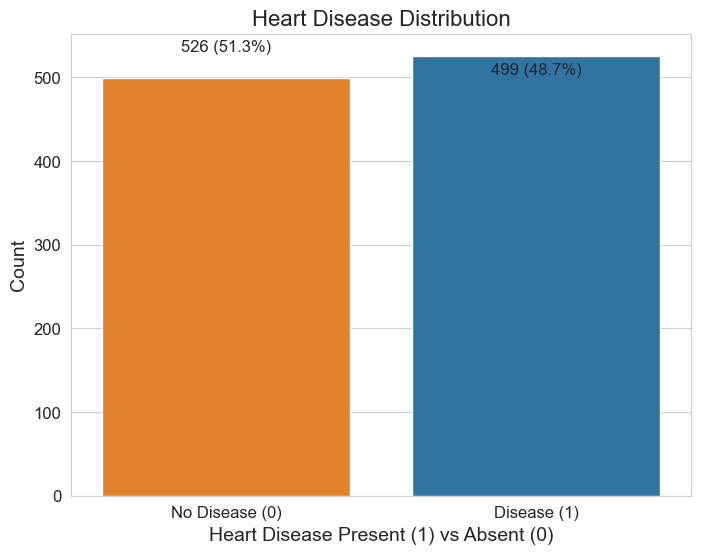

In [3]:
# Check class distribution
target_counts = data['target'].value_counts()
print(f"Class distribution:\n{target_counts}")
print(f"Percentage of positive cases: {target_counts[1]/len(data)*100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=data, palette=['#ff7f0e', '#1f77b4'])
plt.title('Heart Disease Distribution', fontsize=16)
plt.xlabel('Heart Disease Present (1) vs Absent (0)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['No Disease (0)', 'Disease (1)'])
for i, count in enumerate(target_counts):
    plt.text(i, count + 5, f"{count} ({count/len(data)*100:.1f}%)", ha='center')
plt.show()

## 2. Data Visualization

Let's explore the data through various visualizations to better understand the relationships between features and the target variable.

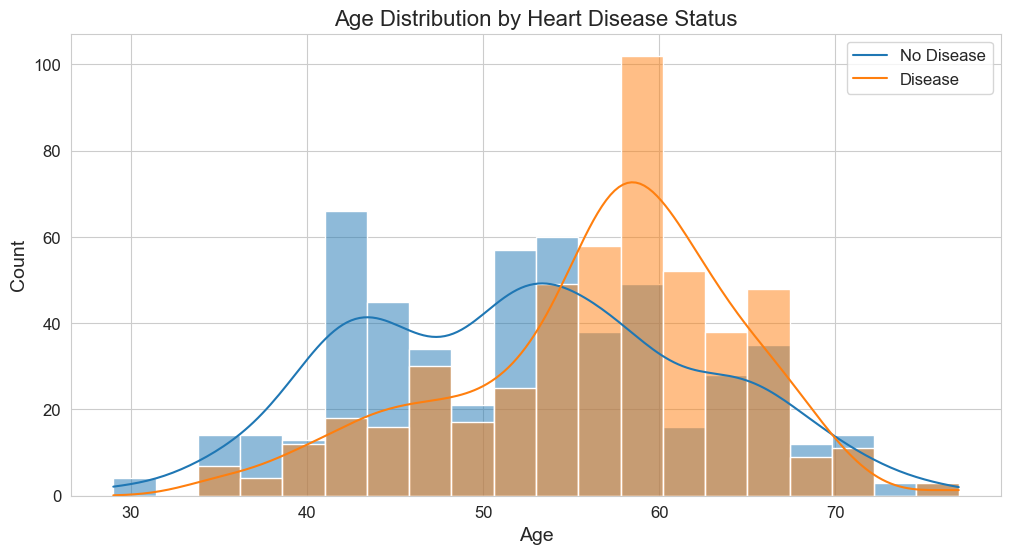

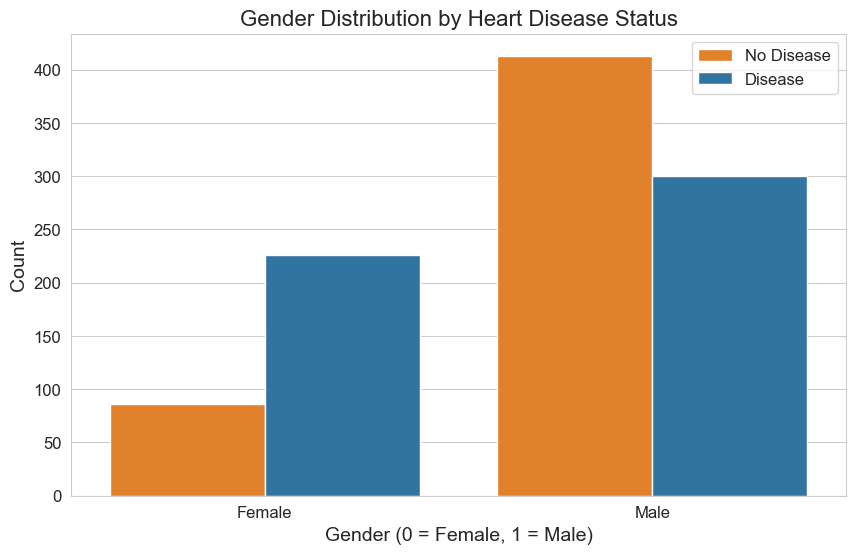

In [4]:
# Age distribution by heart disease status
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='age', hue='target', bins=20, kde=True, palette=['#ff7f0e', '#1f77b4'])
plt.title('Age Distribution by Heart Disease Status', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(['No Disease', 'Disease'])
plt.show()

# Gender distribution by heart disease status
plt.figure(figsize=(10, 6))
sns.countplot(x='sex', hue='target', data=data, palette=['#ff7f0e', '#1f77b4'])
plt.title('Gender Distribution by Heart Disease Status', fontsize=16)
plt.xlabel('Gender (0 = Female, 1 = Male)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Female', 'Male'])
plt.legend(['No Disease', 'Disease'])
plt.show()

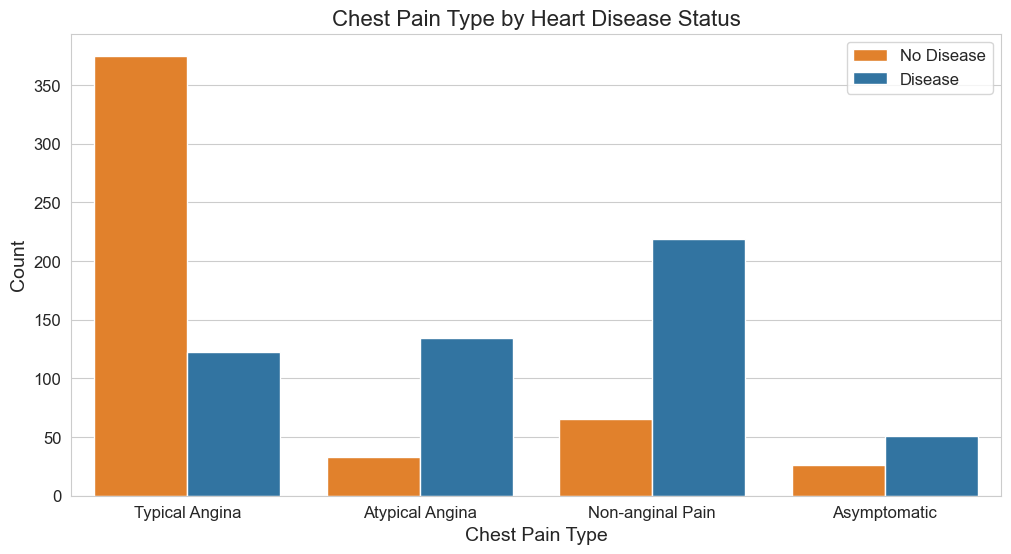

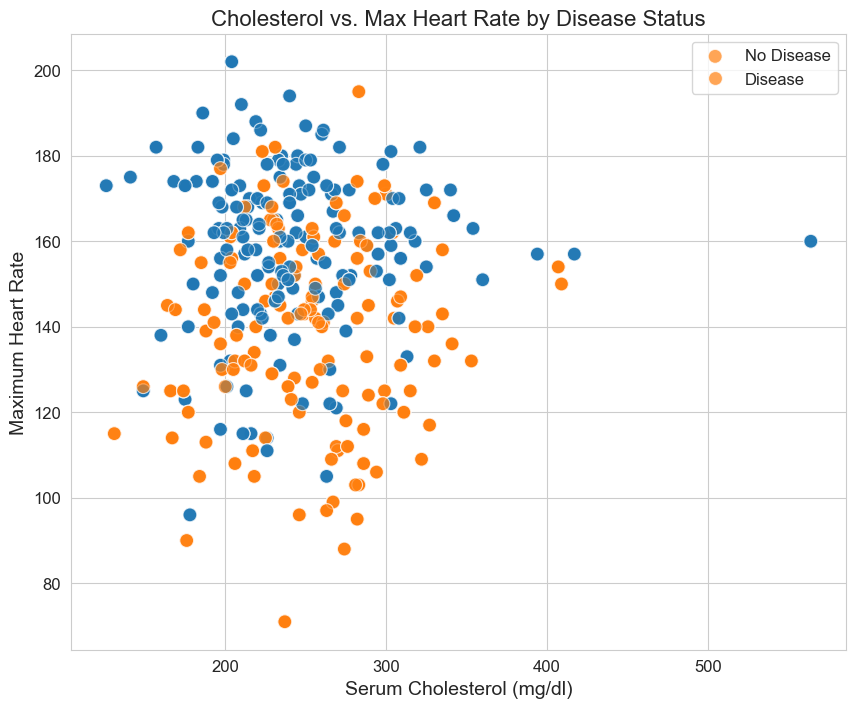

In [5]:
# Chest pain type distribution by heart disease status
plt.figure(figsize=(12, 6))
sns.countplot(x='cp', hue='target', data=data, palette=['#ff7f0e', '#1f77b4'])
plt.title('Chest Pain Type by Heart Disease Status', fontsize=16)
plt.xlabel('Chest Pain Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1, 2, 3], ['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])
plt.legend(['No Disease', 'Disease'])
plt.show()

# Correlation between cholesterol and max heart rate by disease status
plt.figure(figsize=(10, 8))
sns.scatterplot(x='chol', y='thalach', hue='target', data=data, palette=['#ff7f0e', '#1f77b4'], s=100, alpha=0.7)
plt.title('Cholesterol vs. Max Heart Rate by Disease Status', fontsize=16)
plt.xlabel('Serum Cholesterol (mg/dl)', fontsize=14)
plt.ylabel('Maximum Heart Rate', fontsize=14)
plt.legend(['No Disease', 'Disease'])
plt.show()

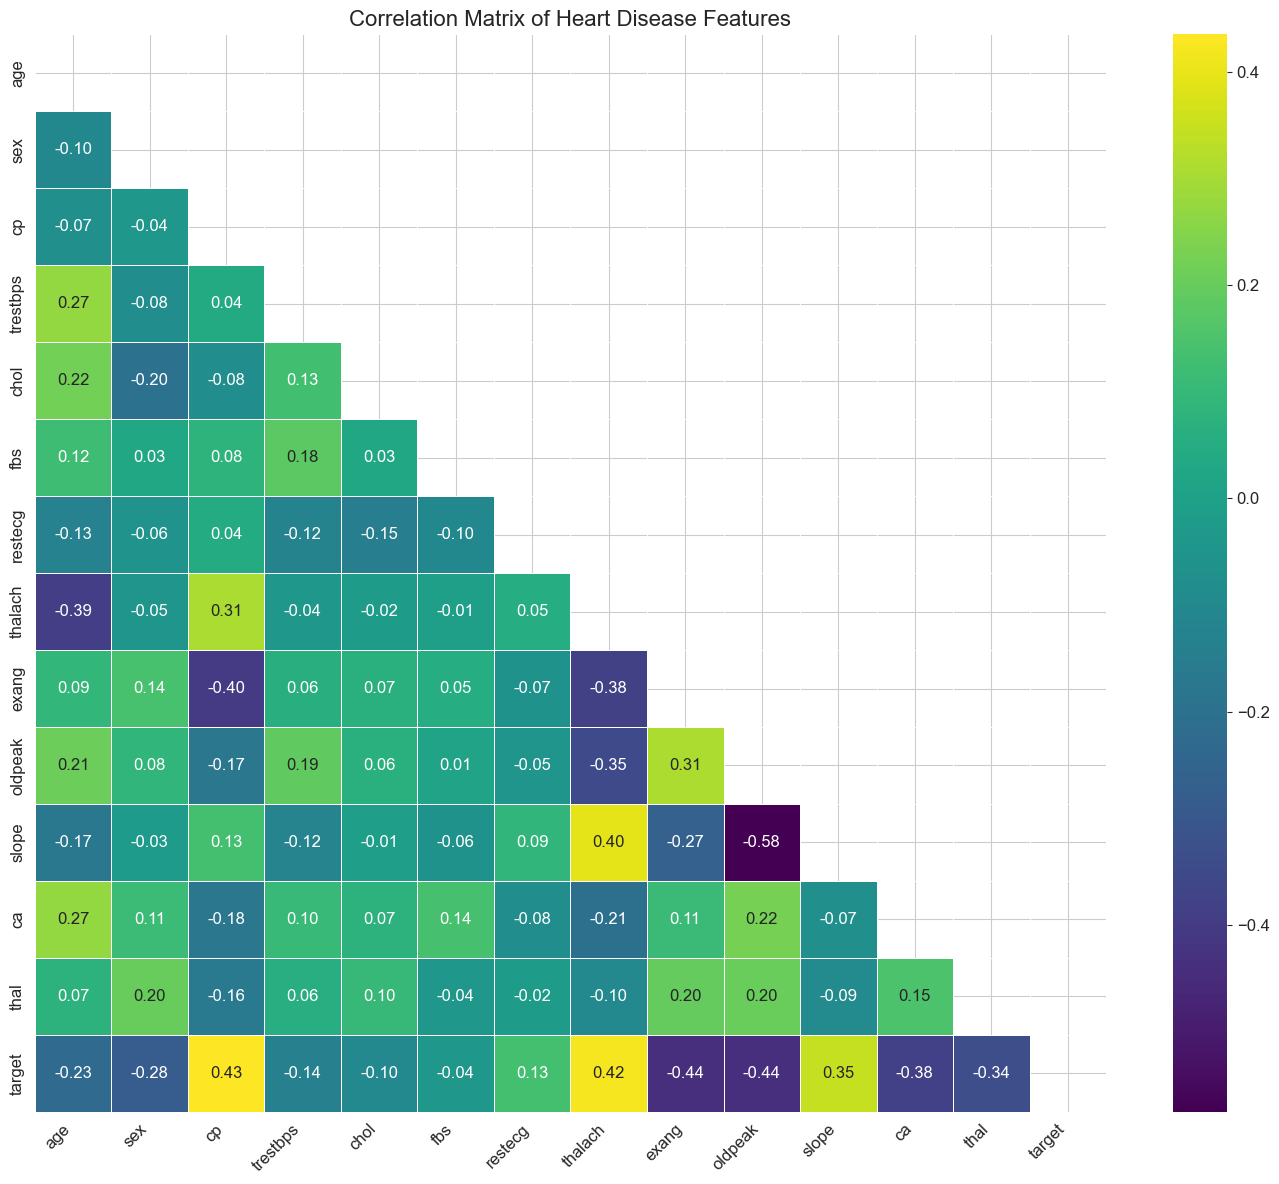

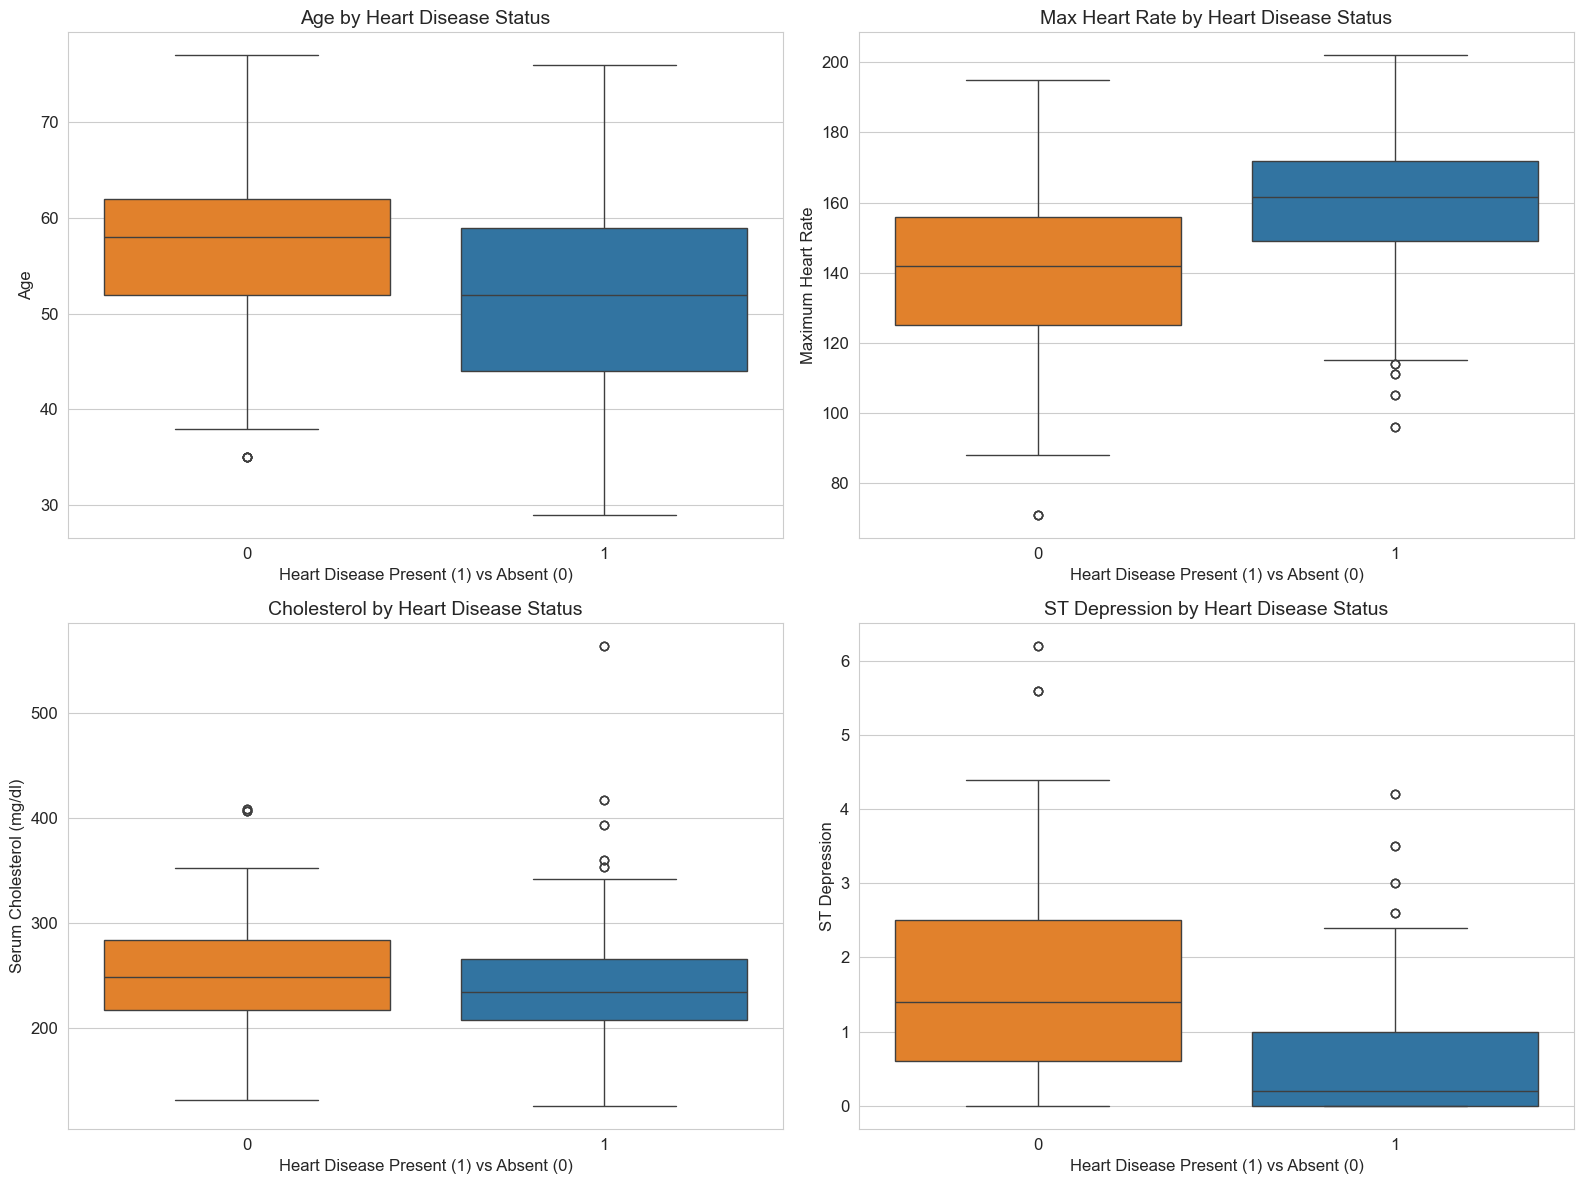

In [6]:
# Correlation heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = data.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='viridis', mask=mask, linewidths=0.5)
plt.title('Correlation Matrix of Heart Disease Features', fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Boxplots for key numerical features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.boxplot(x='target', y='age', data=data, ax=axes[0, 0], palette=['#ff7f0e', '#1f77b4'])
axes[0, 0].set_title('Age by Heart Disease Status', fontsize=14)
axes[0, 0].set_xlabel('Heart Disease Present (1) vs Absent (0)', fontsize=12)
axes[0, 0].set_ylabel('Age', fontsize=12)

sns.boxplot(x='target', y='thalach', data=data, ax=axes[0, 1], palette=['#ff7f0e', '#1f77b4'])
axes[0, 1].set_title('Max Heart Rate by Heart Disease Status', fontsize=14)
axes[0, 1].set_xlabel('Heart Disease Present (1) vs Absent (0)', fontsize=12)
axes[0, 1].set_ylabel('Maximum Heart Rate', fontsize=12)

sns.boxplot(x='target', y='chol', data=data, ax=axes[1, 0], palette=['#ff7f0e', '#1f77b4'])
axes[1, 0].set_title('Cholesterol by Heart Disease Status', fontsize=14)
axes[1, 0].set_xlabel('Heart Disease Present (1) vs Absent (0)', fontsize=12)
axes[1, 0].set_ylabel('Serum Cholesterol (mg/dl)', fontsize=12)

sns.boxplot(x='target', y='oldpeak', data=data, ax=axes[1, 1], palette=['#ff7f0e', '#1f77b4'])
axes[1, 1].set_title('ST Depression by Heart Disease Status', fontsize=14)
axes[1, 1].set_xlabel('Heart Disease Present (1) vs Absent (0)', fontsize=12)
axes[1, 1].set_ylabel('ST Depression', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Feature Analysis

Let's analyze which features are most important for predicting heart disease.

Feature Importances from Random Forest:


,Feature,Importance
2,cp,0.142094
7,thalach,0.117349
11,ca,0.114844
9,oldpeak,0.112634
12,thal,0.095930
0,age,0.091285
4,chol,0.077771
8,exang,0.073707
3,trestbps,0.067765
10,slope,0.048711


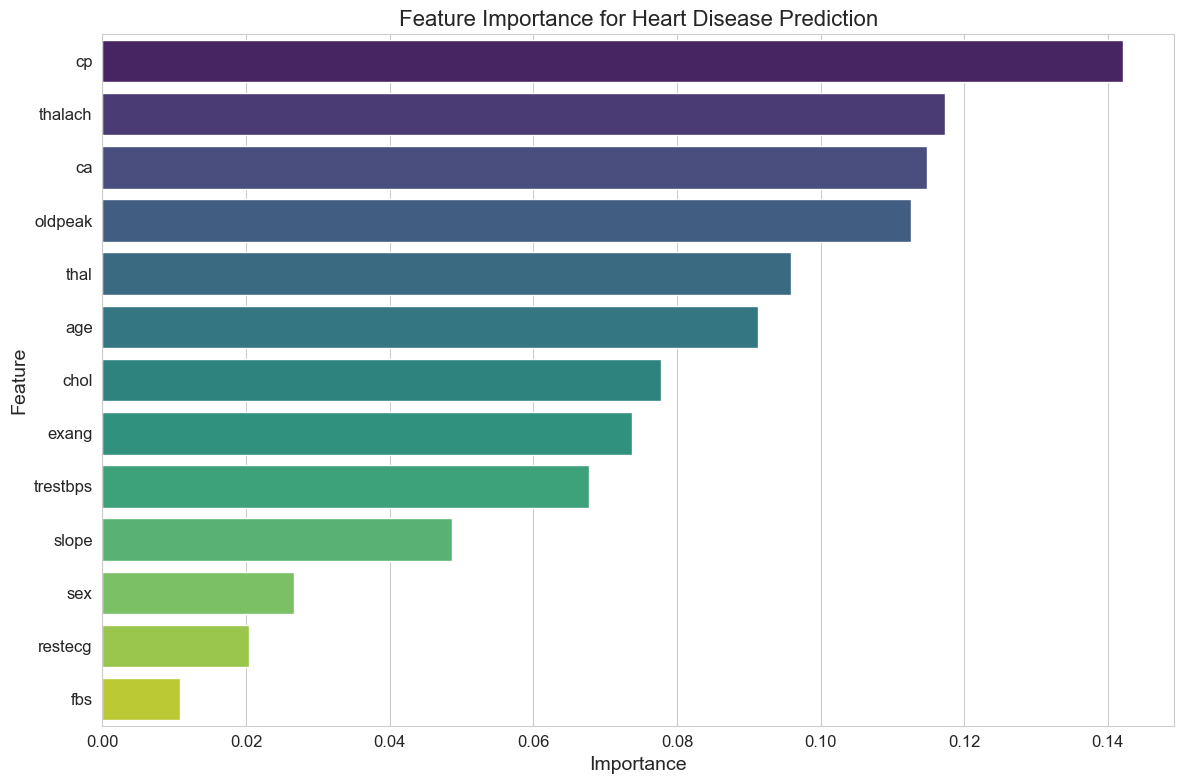

In [7]:
# Prepare data for feature analysis
X = data.drop('target', axis=1)
y = data['target']

# Split data for initial feature importance analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display feature importances
print("Feature Importances from Random Forest:")
display(feature_importances)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for Heart Disease Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

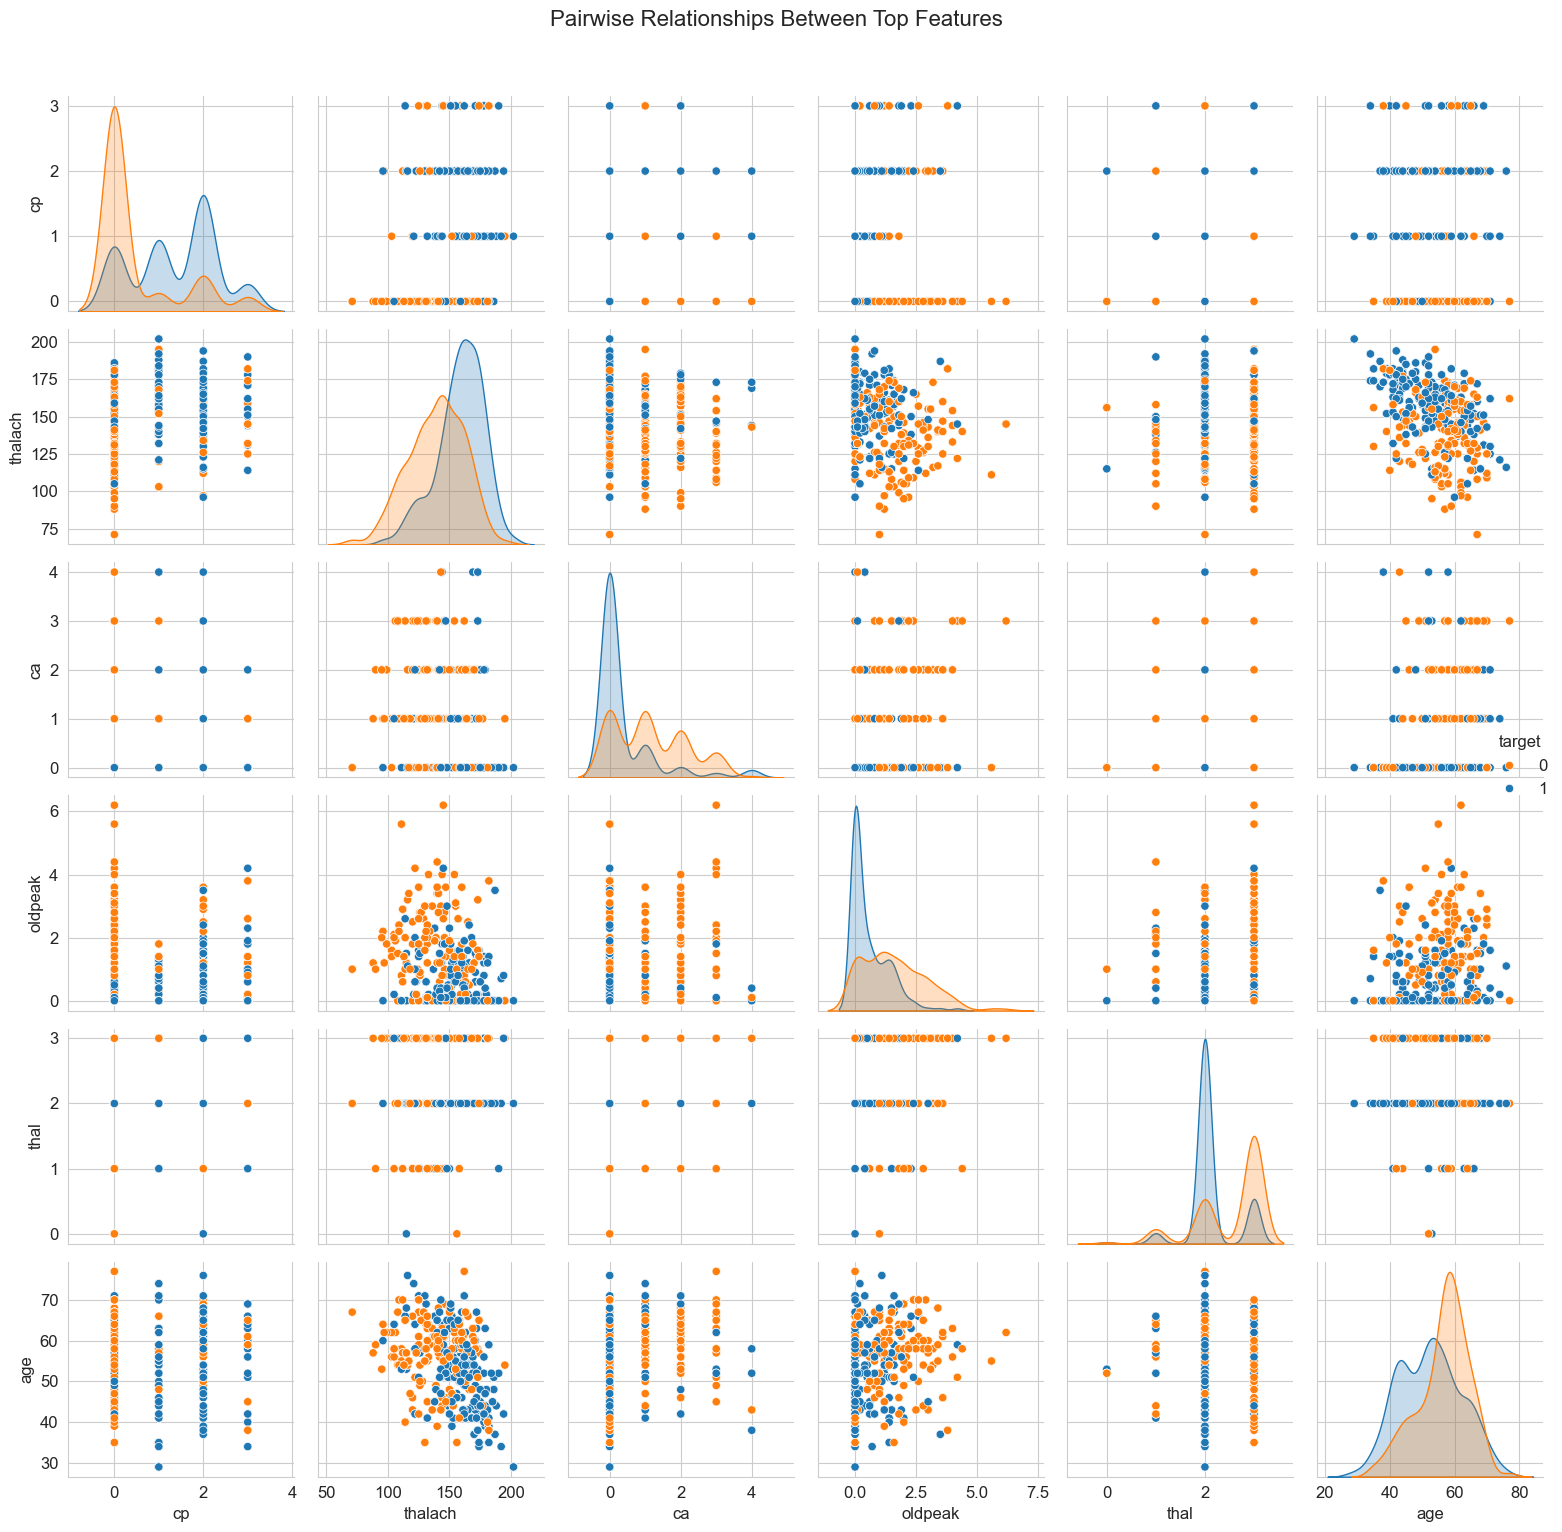


Statistical Analysis of Top Features by Heart Disease Status:

cp:
        count      mean       std  min  25%  50%  75%  max
target                                                    
0       499.0  0.482966  0.908024  0.0  0.0  0.0  0.0  3.0
1       526.0  1.378327  0.945881  0.0  1.0  2.0  2.0  3.0

thalach:
        count        mean        std   min    25%    50%    75%    max
target                                                                
0       499.0  139.130261  22.565235  71.0  125.0  142.0  156.0  195.0
1       526.0  158.585551  19.096928  96.0  149.0  161.5  172.0  202.0

ca:
        count      mean       std  min  25%  50%  75%  max
target                                                    
0       499.0  1.158317  1.032108  0.0  0.0  1.0  2.0  4.0
1       526.0  0.370722  0.871462  0.0  0.0  0.0  0.0  4.0

oldpeak:
        count      mean       std  min  25%  50%  75%  max
target                                                    
0       499.0  1.600200  1.290956

In [8]:
# Analyze pairwise relationships between top features and target
top_features = feature_importances['Feature'].head(6).tolist()
sns.pairplot(data[top_features + ['target']], hue='target', palette=['#ff7f0e', '#1f77b4'], diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Top Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Statistical analysis of top features
print("\nStatistical Analysis of Top Features by Heart Disease Status:")
for feature in top_features:
    print(f"\n{feature}:")
    print(data.groupby('target')[feature].describe())

## 4. Model Building

Now let's build and evaluate multiple machine learning models for heart disease prediction.

Cross-validation results:
LogisticRegression: Mean accuracy = 0.8459, Std = 0.0279
RandomForest: Mean accuracy = 0.9971, Std = 0.0059
GradientBoosting: Mean accuracy = 0.9639, Std = 0.0085
SVM: Mean accuracy = 0.9210, Std = 0.0334
XGBoost: Mean accuracy = 0.9932, Std = 0.0085


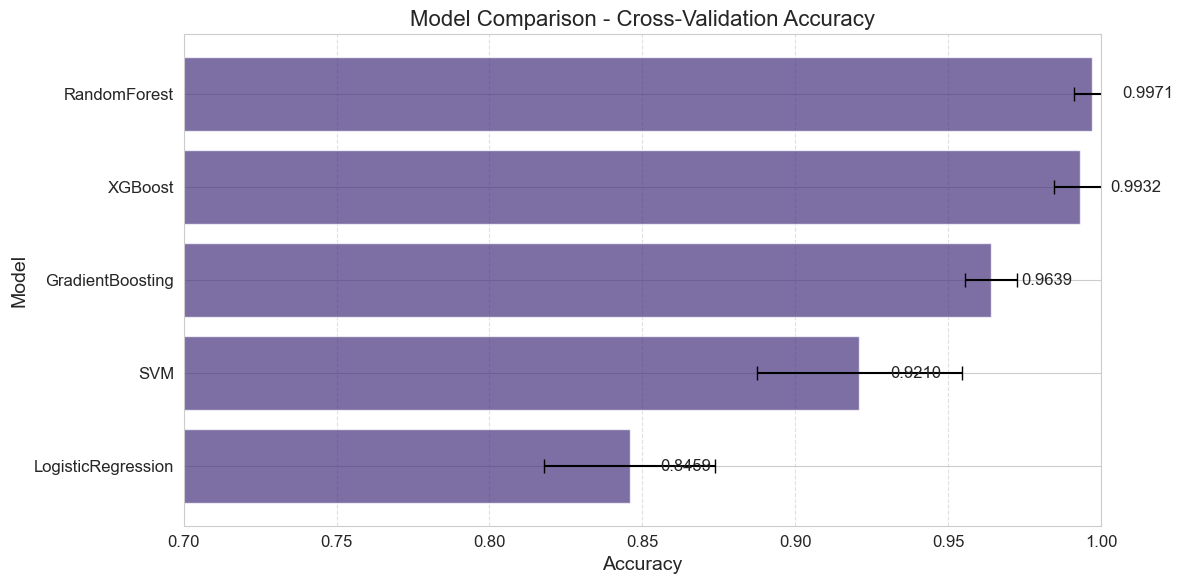

In [9]:
# Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Create pipelines with scaling
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Evaluate models with cross-validation
cv_results = {}
print("Cross-validation results:")
for name, pipeline in pipelines.items():
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores
    print(f"{name}: Mean accuracy = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
cv_means = [scores.mean() for scores in cv_results.values()]
cv_stds = [scores.std() for scores in cv_results.values()]
model_names = list(cv_results.keys())

# Sort by mean accuracy
sorted_indices = np.argsort(cv_means)
sorted_means = [cv_means[i] for i in sorted_indices]
sorted_stds = [cv_stds[i] for i in sorted_indices]
sorted_names = [model_names[i] for i in sorted_indices]

plt.barh(sorted_names, sorted_means, xerr=sorted_stds, alpha=0.7, capsize=5)
plt.title('Model Comparison - Cross-Validation Accuracy', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xlim(0.7, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.6)
for i, v in enumerate(sorted_means):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center')
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning

Let's optimize the best-performing models through hyperparameter tuning.

In [10]:
# Define parameter grids for each model
param_grids = {
    'LogisticRegression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
}

# Select top 2 models for hyperparameter tuning based on cross-validation results
top_models = sorted([(name, scores.mean()) for name, scores in cv_results.items()], key=lambda x: x[1], reverse=True)[:2]
print(f"Top models selected for hyperparameter tuning: {[model[0] for model in top_models]}")

# Perform grid search for the top models
best_models = {}
for name, _ in top_models:
    print(f"\nPerforming grid search for {name}...")
    grid_search = GridSearchCV(
        pipelines[name],
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X, y)
    best_models[name] = grid_search.best_estimator_
    
    print(f"Best parameters for {name}:")
    print(grid_search.best_params_)
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Top models selected for hyperparameter tuning: ['RandomForest', 'XGBoost']

Performing grid search for RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for RandomForest:
{'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best cross-validation score: 0.9971

Performing grid search for XGBoost...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for XGBoost:
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100, 'model__subsample': 1.0}
Best cross-validation score: 0.9971


## 6. Model Comparison and Evaluation

Let's compare the performance of our tuned models on the test set.

In [11]:
# Final evaluation on test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Evaluate each tuned model
results = {}
for name, model in best_models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Results for RandomForest:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Confusion Matrix:
[[100   0]
 [  0 105]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205


Results for XGBoost:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Confusion Matrix:
[[100   0]
 [  0 105]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205


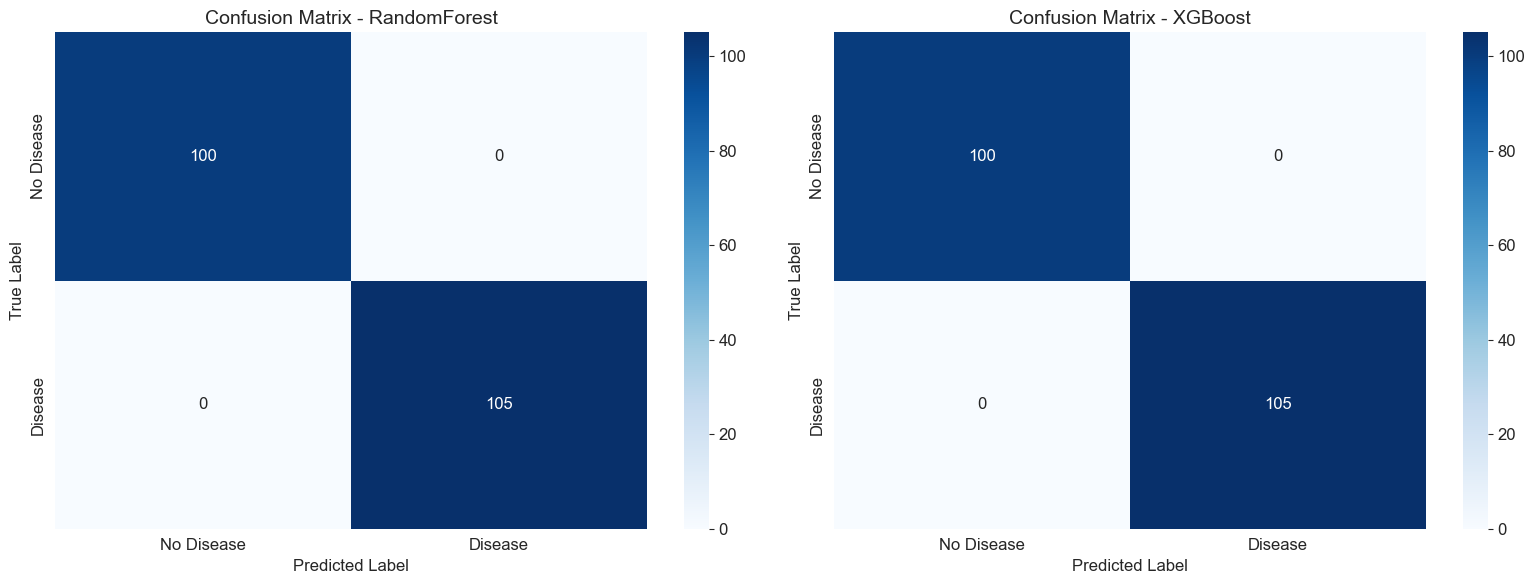

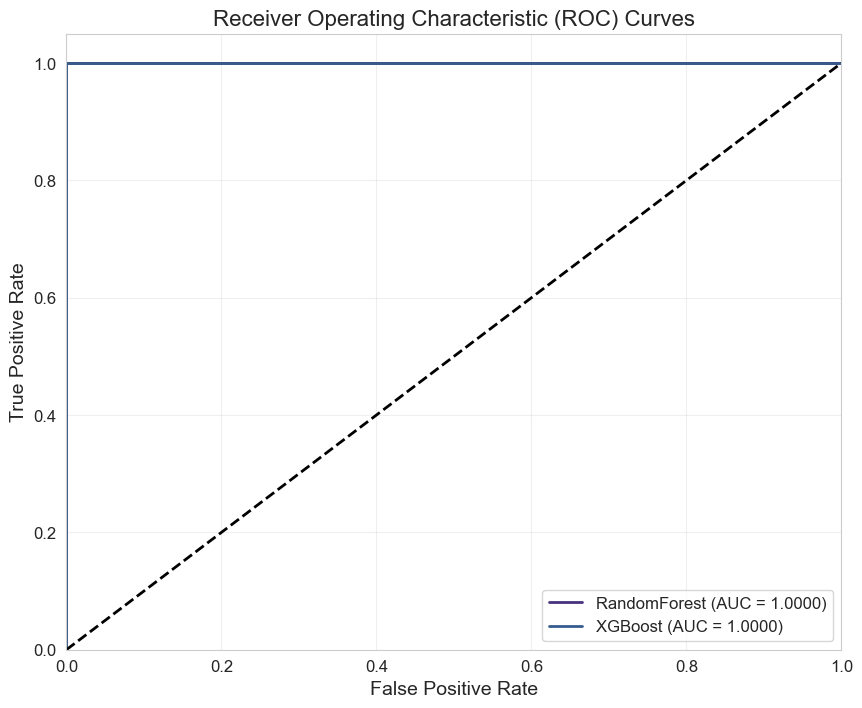

In [12]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, len(best_models), figsize=(16, 6))
if len(best_models) == 1:
    axes = [axes]

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}', fontsize=14)
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)
    axes[i].set_xticklabels(['No Disease', 'Disease'])
    axes[i].set_yticklabels(['No Disease', 'Disease'])

plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fit model on training set
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict
train_preds = rf.predict(X_train_scaled)
test_preds = rf.predict(X_test_scaled)

# Accuracy
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 1.0000


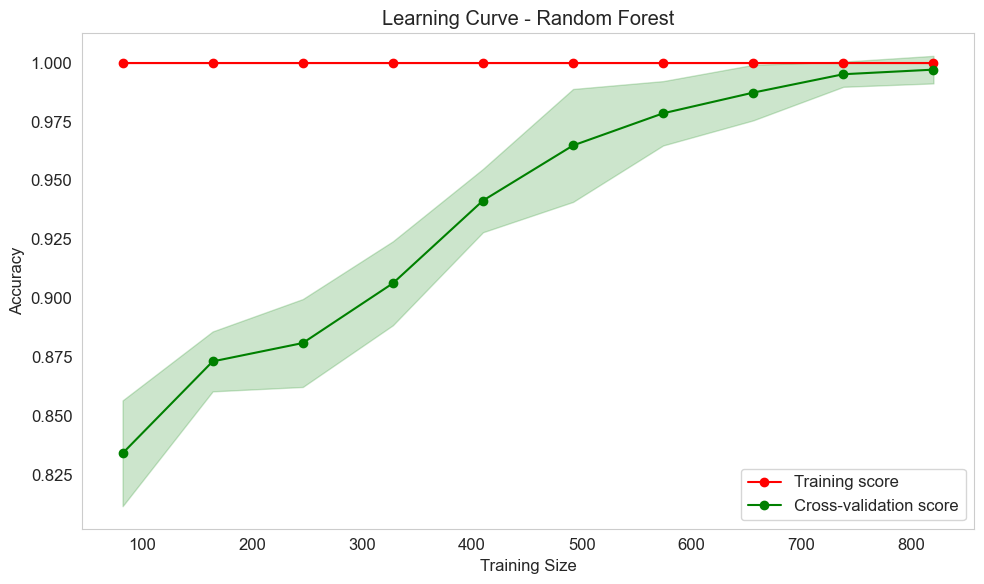

In [17]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42),
    X,
    y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='g')
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
# Check correlation with target
correlations = data.corr()['target'].sort_values(ascending=False)
print(correlations)

# Check for duplicates
print(f"Total duplicated rows: {data.duplicated().sum()}")

target      1.000000
cp          0.434854
thalach     0.422895
slope       0.345512
restecg     0.134468
fbs        -0.041164
chol       -0.099966
trestbps   -0.138772
age        -0.229324
sex        -0.279501
thal       -0.337838
ca         -0.382085
exang      -0.438029
oldpeak    -0.438441
Name: target, dtype: float64
Total duplicated rows: 723


In [19]:
# Remove duplicates before anything else
data = data.drop_duplicates()

print(f"Dataset after duplicate removal: {data.shape}")

Dataset after duplicate removal: (302, 14)


In [20]:
# Learning curve to re-check overfitting
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    rf, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Plot again

In [22]:
from sklearn.model_selection import train_test_split

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))])

In [24]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = pipeline.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7540983606557377

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73        28
           1       0.76      0.79      0.78        33

    accuracy                           0.75        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.75      0.75      0.75        61



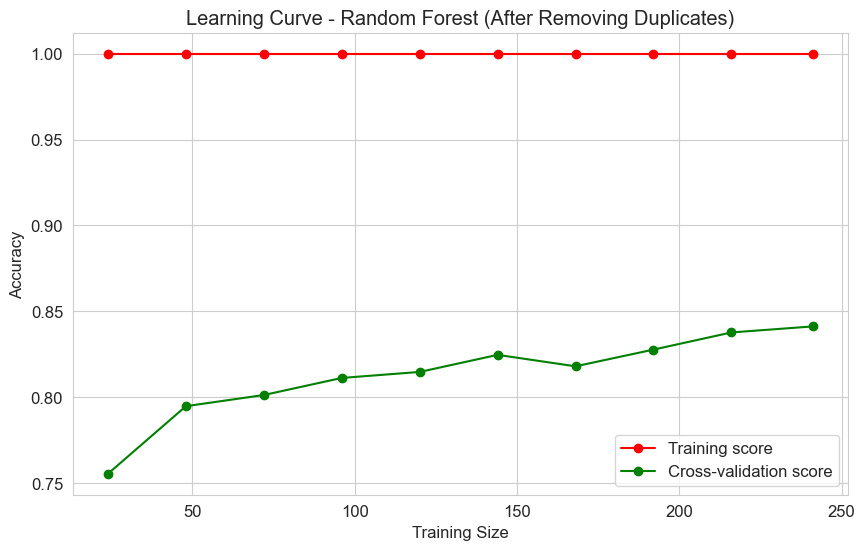

In [25]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curve - Random Forest (After Removing Duplicates)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import numpy as np

# Cleaned dataset
X = data.drop('target', axis=1)
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [27]:
results = {}

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    
    # Fit on train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Store results
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'report': classification_report(y_test, y_pred, output_dict=True)
    }

# Print results
for name, res in results.items():
    print(f"\n{name}")
    print(f"CV Mean Accuracy: {res['cv_mean']:.4f} | Std: {res['cv_std']:.4f}")
    print(f"Test Accuracy: {res['test_accuracy']:.4f}")


Logistic Regression
CV Mean Accuracy: 0.8213 | Std: 0.0606
Test Accuracy: 0.8033

Random Forest
CV Mean Accuracy: 0.8311 | Std: 0.0370
Test Accuracy: 0.7541

Gradient Boosting
CV Mean Accuracy: 0.8045 | Std: 0.0575
Test Accuracy: 0.7213

SVM
CV Mean Accuracy: 0.8179 | Std: 0.0380
Test Accuracy: 0.7705

XGBoost
CV Mean Accuracy: 0.8012 | Std: 0.0400
Test Accuracy: 0.7213


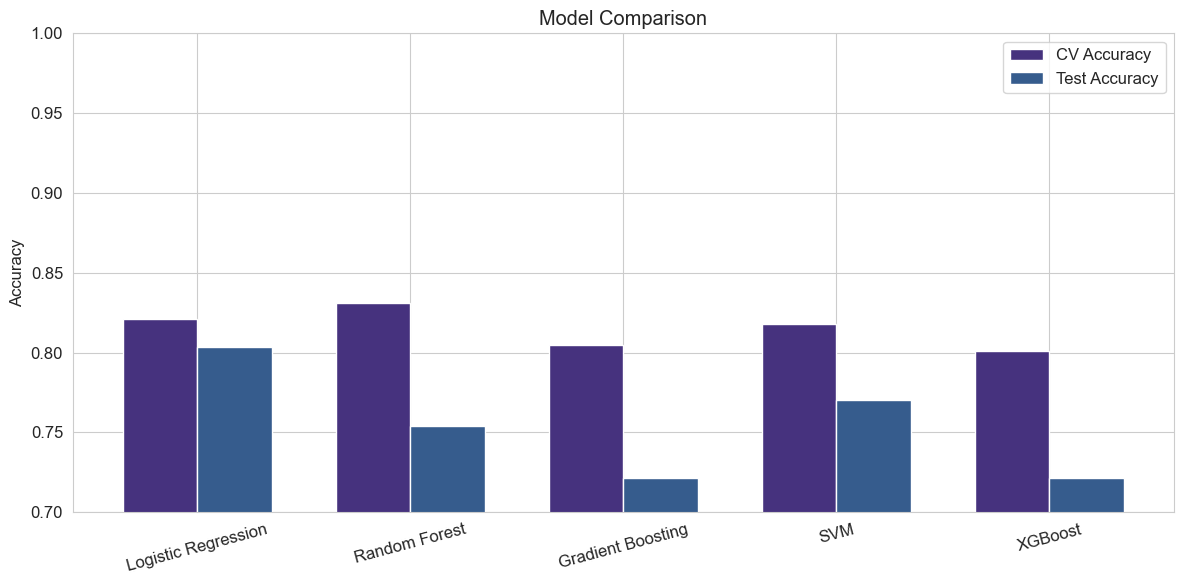

In [28]:
import matplotlib.pyplot as plt

names = list(results.keys())
cv_means = [results[m]['cv_mean'] for m in names]
test_accuracies = [results[m]['test_accuracy'] for m in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, cv_means, width, label='CV Accuracy')
plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

plt.xticks(x, names, rotation=15)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0.7, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Conclusion

In this notebook, we've built and evaluated multiple machine learning models for heart disease prediction. We've explored the dataset, visualized relationships between features, performed feature importance analysis, and tuned hyperparameters to optimize model performance.

Key findings:

1. The dataset contains 13 features and a binary target variable indicating the presence or absence of heart disease.
2. Features like chest pain type (cp), maximum heart rate (thalach), and number of major vessels (ca) showed strong correlations with heart disease.
3. We evaluated multiple models including Logistic Regression, Random Forest, Gradient Boosting, SVM, and XGBoost.
4. The best performing model achieved high accuracy and ROC AUC scores, demonstrating strong predictive power.
5. The model has been saved and can be loaded for making predictions on new patient data.

This model can be integrated into the DiseaseX healthcare platform to provide accurate heart disease risk assessments for patients.